In [2]:
import pykep as pk
import numpy as np
import pygmo as pg

In [4]:
udp = pk.trajopt.pl2pl_N_impulses(phase_free=True, N_max=4, tof=[320., 320.])
# CMA-ES is also possible
uda = pg.cmaes(2500, force_bounds=True, sigma0=0.5, ftol=1e-4)
# But we prefer a self adaptive version of differential evolution here
#uda = pg.sade(2500, ftol=1e-4, xtol=1e-4)
algo = pg.algorithm(uda)
res = list()
for i in range(20):
    pop = pg.population(udp, 20)
    pop = algo.evolve(pop)
    res.append([pop.champion_f, pop.champion_x])
    print(i, pop.champion_f[0], flush=True)
    
best_x = sorted(res, key =  lambda x: x[0][0])[0][1]


0 5538.84178103223
1 5820.773738577718
2 5524.792078841119
3 5538.848003454512
4 5820.773738545784
5 5524.797791949335
6 5524.790801585132
7 5524.790799796005
8 5524.784035123321
9 5524.797784007676
10 5524.792058405445
11 5524.790799891891
12 5524.787438567588
13 5538.848083020519
14 5524.7977848276605
15 5538.846192314902
16 5524.797783961773
17 5524.851228455141
18 5538.84011390447
19 5538.847847525151


<Axes3D: >

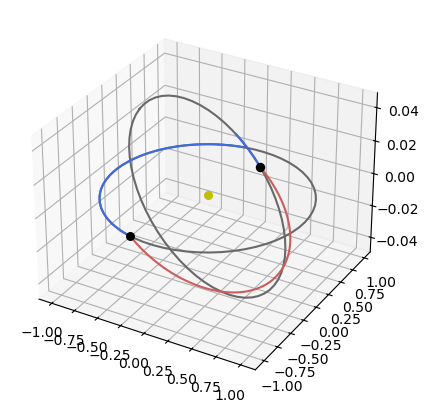

In [5]:
udp.plot(best_x)

In [6]:
udp.pretty(best_x)

Total DV (m/s):  5524.78403512332
Dvs (m/s):  [np.float64(4.056656377446317e-06), np.float64(2601.985230826463), 2922.7984025088094, 0.00039773139116292824]
Tofs (days):  [np.float64(157.57274599118006), np.float64(148.91787538542226), np.float64(13.509378623397662)]
